idea: building a classification model to predict if a public university is closed or open

In [ ]:
#load in all finance data
import pandas as pd
import numpy as np
import seaborn as sns

#loading in all financial data for public schools
data_2015 = pd.read_csv("f1415_f1a.csv")
data_2016 = pd.read_csv("f1516_f1a.csv")
data_2017 = pd.read_csv("f1617_f1a.csv")
data_2018 = pd.read_csv("f1718_f1a.csv")
data_2019 = pd.read_csv("f1819_f1a.csv")
data_2020 = pd.read_csv("f1920_f1a.csv")
data_2021 = pd.read_csv("f2021_f1a.csv")
data_2022 = pd.read_csv("f2122_f1a.csv")
data_2023 = pd.read_csv("f2223_f1a.csv")

#creating a list of dataframes to combine
data_frames = [data_2015, data_2016, data_2017, data_2018, data_2019, data_2020, data_2021, data_2022, data_2023]

In [ ]:
#updating data frames to include the year
data_2015["year"] = 2015
data_2016["year"] = 2016
data_2017["year"] = 2017
data_2018["year"] = 2018
data_2019["year"] = 2019
data_2020["year"] = 2020
data_2021["year"] = 2021
data_2022["year"] = 2022
data_2023["year"] = 2023

In [ ]:
#every data frame is comnined with the year of the row included

data = pd.concat(data_frames) #full data of all the public schools

#viewing data frame
data.head()

,UNITID,XF1A01,F1A01,XF1A31,F1A31,XF1A04,F1A04,XF1A05,F1A05,XF1A06,...,XF1N03,F1N03,XF1N04,F1N04,XF1N05,F1N05,XF1N06,F1N06,XF1N07,F1N07
0,100654,R,7.853571e+07,R,1.157264e+08,R,1.342300e+04,R,1.157398e+08,R,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,100663,R,1.204895e+09,R,1.538321e+09,R,1.211609e+09,R,2.749930e+09,R,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,100706,R,1.424860e+08,R,2.383018e+08,R,7.910217e+07,R,3.174039e+08,R,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,100724,R,4.602033e+07,R,2.988681e+08,R,1.663636e+07,R,3.155044e+08,R,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,100733,R,4.503448e+06,R,1.334091e+07,R,8.826359e+06,R,2.216727e+07,R,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**Assumption**
 if a schools id is not in the final year in the dataset (2023) that means it has closed at some point

 plan:
 create a function to find the last year a school appears in the dataset and turn that to be 1 to represent final financials before the school closed...

 This is so that all of the other years the school was open.. that id will be treated as a open school and represented by 0

In [ ]:
#checking how many rows are in each year:
data["year"].value_counts()

,count
year,
2015,1986
2016,1986
2017,1978
2018,1964
2019,1961
2020,1949
2021,1946
2022,1936
2023,1916


In [ ]:
def create_target_column(data):
    # Find the last year each UNITID appears
    last_year_open = data.groupby("UNITID")["year"].max().reset_index()
    last_year_open.rename(columns={'year': 'last_year_open'}, inplace=True)

    # Merge the last_year_open column back into the original data
    data = data.merge(last_year_open, on="UNITID", how="left")

    # Create the target column and initialize it to 0
    data["target"] = 0

    # Set target = 1 for rows where the year matches the last_year_open
    # EXCEPT for UNITIDs that appear in 2023
    data.loc[(data["year"] == data["last_year_open"]) &
             (~data["UNITID"].isin(data[data["year"] == 2023]["UNITID"])), "target"] = 1

    # Drop the last_year_open column as it's no longer needed
    data.drop(columns=["last_year_open"], inplace=True)

    return data

In [ ]:
data = create_target_column(data)

In [ ]:
#checking how many rows are classified as 1 (closed) and 0 (open) out of all the public schools
data["target"].value_counts()

,count
target,
0,17516
1,106


In [ ]:
#here is an example of what the function does:
data[data["UNITID"] == 431187][["UNITID","target", "year"]].reset_index().drop(["index"], axis = 1)

,UNITID,target,year
0,431187,0,2015
1,431187,0,2016
2,431187,0,2017
3,431187,0,2018
4,431187,0,2019
5,431187,0,2020
6,431187,0,2021
7,431187,1,2022


In [ ]:
#creating numerical data frame
n_data = data.select_dtypes(include = ["number"])

**Feature selection** ⬇

trying to select the strongest predictors to if a public school is open or closed and then removing features that have multi-colinearity

In [ ]:
#creating a random forest model to get feature importance of variables

from sklearn.model_selection import train_test_split

X = n_data.drop(["target"], axis = 1)
y = n_data["target"]

from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight= "balanced")
rf_model.fit(X, y)

# Get feature importances:
feature_names = X.columns
rf_importance = pd.Series(rf_model.feature_importances_, index=feature_names)
sorted_rf_importance = rf_importance.sort_values(ascending=False)

#these are the 6 most important variables to predicting open or closed
print(sorted_rf_importance.head(6))

F1B24     0.027991
F1E01     0.023020
F1B14     0.022112
F1C071    0.020093
F1C191    0.018585
F1C072    0.017939
dtype: float64


In [ ]:
#the most important variable to predicting if a school is open or closed is F1B24
#total other revenues and additions (donations, grants.. etc)

n_data.groupby("target")["F1B24"].mean()

,F1B24
target,
0,1.112105e+07
1,3.203959e+05


<Figure size 1000x700 with 0 Axes>

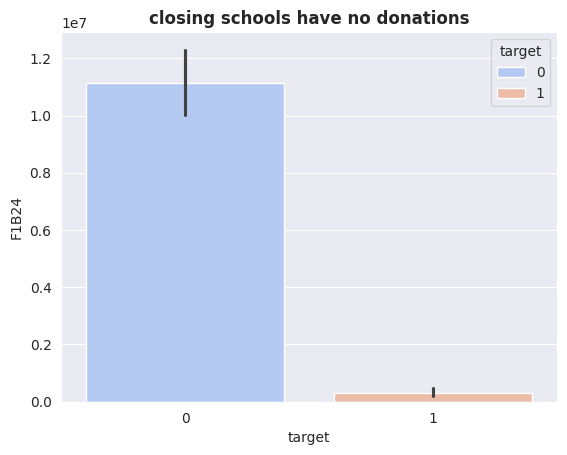

<Figure size 1000x700 with 0 Axes>

In [ ]:
#1.112105e+07 is equivalent to 11,121,050, 3.203959e+05 is equivalent to 320,395.9

import matplotlib.pyplot as plt

sns.set_style("darkgrid")
sns.barplot(data = n_data, x = "target", y= "F1B24", hue = "target", palette = "coolwarm")
plt.title("closing schools have no donations", fontdict={"weight" : "bold"})
plt.figure(figsize = (10, 7 ))

<Figure size 1000x700 with 0 Axes>

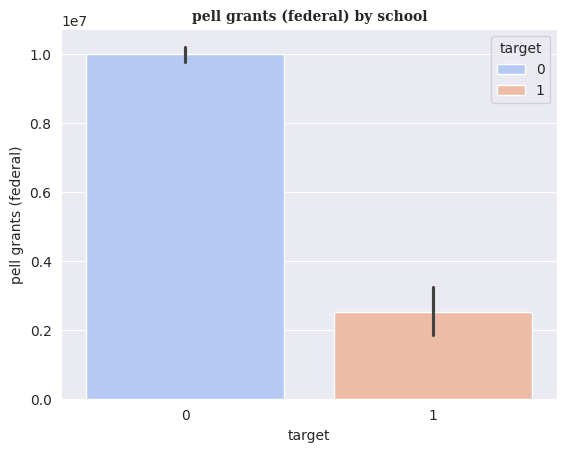

<Figure size 1000x700 with 0 Axes>

In [ ]:
sns.barplot(data = n_data, x = "target", y = "F1E01", hue = "target", palette = "coolwarm")
plt.title("pell grants (federal) by school", fontdict={"weight": "bold", "font" : "serif"})
plt.ylabel("pell grants (federal)")
plt.figure(figsize = (10, 7))

<Figure size 1000x700 with 0 Axes>

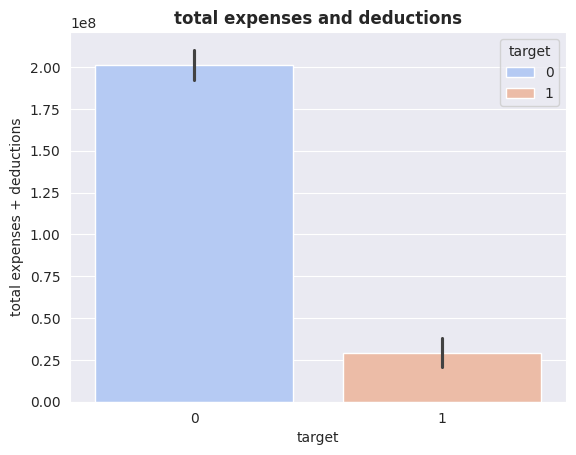

<Figure size 1000x700 with 0 Axes>

In [ ]:
sns.barplot(data = n_data, x = n_data["target"], y = n_data["F1C191"], hue = "target", palette = "coolwarm")
plt.title("total expenses and deductions", fontdict = {"weight" : "bold"})
plt.ylabel("total expenses + deductions")
plt.figure(figsize = (10, 7))

In [ ]:
#taking the target variable for visualizations and top 5 predictors of "target" to create model data....
full_model_data = n_data[["target", "F1C191", "F1C071", "F1B14", "F1E01", "F1B24", "F1C072"]]

In [ ]:
#renaming columns
full_model_data.rename(columns = {"F1C191" : "total_expenses", "F1E01": "federal_grants", "F1B24" : "other_revenues", "F1C071" : "institutional_support", "F1C072" : "salary_support", "F1B14" : "non_operating grants"}, inplace = True)

<ipython-input-17-77db7cb5405a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_model_data.rename(columns = {"F1C191" : "total_expenses", "F1E01": "federal_grants", "F1B24" : "other_revenues", "F1C071" : "institutional_support", "F1C072" : "salary_support", "F1B14" : "non_operating grants"}, inplace = True)


In [ ]:
full_model_data.head()

,target,total_expenses,institutional_support,non_operating grants,federal_grants,other_revenues,salary_support
0,0,152235091,31906733,0,14654328.0,0,10190948
1,0,2508244599,135140397,115969,17673156.0,24620842,48377746
2,0,210197406,23796728,0,7670824.0,258364,11181017
3,0,143364693,32484351,0,16340329.0,47886,9794792
4,0,18096750,0,0,NaN,0,0


In [ ]:
correlation_data = full_model_data.drop(["target"], axis = 1).corr()

Text(0.5, 1.0, 'strong multicolinearity in 3 variables')

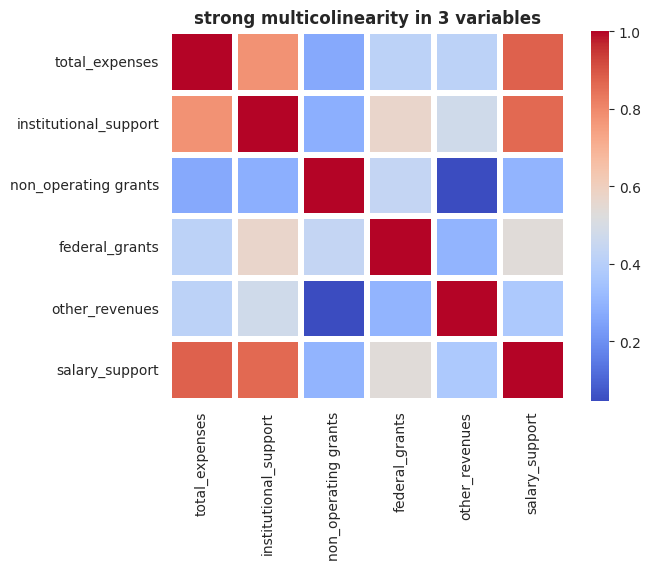

In [ ]:
sns.heatmap(correlation_data, lw = 4, linecolor = "white", cmap = "coolwarm")
plt.title("strong multicolinearity in 3 variables", fontdict= {"weight" : "bold"})

In [ ]:
#salary support has multi-colinearity with total_expenses and instutional support
correlation_data[["salary_support","institutional_support", "total_expenses"]].sort_values(by = "salary_support", ascending = False).sum()

#took the sum of each highly correlated varibale of thier correlation with the other variables in the data frame to see which one had the lowest
#so we will keep total_expenses and remove institutional_support and salary_support...

#most likley salary support and institutional support are included in the umbrella term total_expenses

,0
salary_support,3.952437
institutional_support,3.974110
total_expenses,3.759759


In [ ]:
model_data = full_model_data.drop(["salary_support", "institutional_support"], axis = 1)

In [ ]:
model_data.head()

,target,total_expenses,non_operating grants,federal_grants,other_revenues
0,0,152235091,0,14654328.0,0
1,0,2508244599,115969,17673156.0,24620842
2,0,210197406,0,7670824.0,258364
3,0,143364693,0,16340329.0,47886
4,0,18096750,0,NaN,0


In [ ]:
new_correlation_data = model_data.drop(["target"], axis = 1).corr()

In [ ]:
new_correlation_data

,total_expenses,non_operating grants,federal_grants,other_revenues
total_expenses,1.000000,0.269259,0.415623,0.417350
non_operating grants,0.269259,1.000000,0.440980,0.045952
federal_grants,0.415623,0.440980,1.000000,0.298377
other_revenues,0.417350,0.045952,0.298377,1.000000


Text(0.5, 1.0, 'feature selection heatmap')

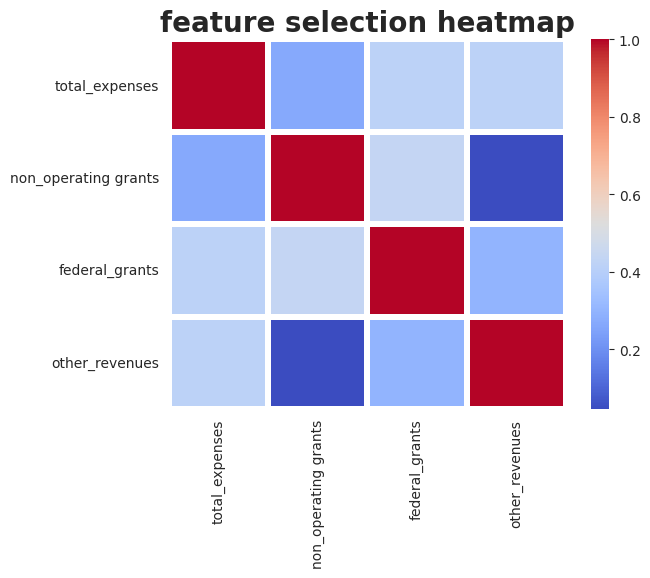

In [ ]:
#creating a heatmap after dropping multi colinearity
sns.heatmap(new_correlation_data, lw= 4, linecolor = "white", cmap = "coolwarm")
plt.title("feature selection heatmap", fontdict={"weight":"bold", "size" : "20"})

**now we have 4 strong predictors without any multicolinearity**

**now preprocessing, splitting data, and building logisstic regression**

In [ ]:
model_data = model_data.dropna()

In [ ]:
#going to randonly undersample open schools to balance the data..

import random

# Split the dataset into open and closed schools
open_schools = model_data[model_data["target"] == 0]
closed_schools = model_data[model_data["target"] == 1]

# Number of random open schools to select
num_samples = len(closed_schools)

# Select random schools using `.sample()`
random_open_schools = open_schools.sample(n=num_samples, random_state=42)


In [ ]:

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# Split open and closed schools properly
random_open_train, random_open_test = train_test_split(random_open_schools, test_size=0.25, random_state=42)
closed_train, closed_test = train_test_split(closed_schools, test_size=0.25, random_state=42)

# Create train and test datasets
final_data = pd.concat([random_open_train, closed_train]).dropna()
test_data = pd.concat([random_open_test, closed_test]).dropna()

# Define features and target
X_train = final_data.drop(["target"], axis=1)
y_train = final_data["target"]

X_test = test_data.drop(["target"], axis=1)
y_test = test_data["target"]

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train logistic regression
model = LogisticRegression()
model.fit(X_train_scaled, y_train)

# Make predictions
ypreds = model.predict(X_test_scaled)

# Evaluate model
print(classification_report(y_test, ypreds))
cm = confusion_matrix(y_test, ypreds)


              precision    recall  f1-score   support

           0       0.95      0.69      0.80        26
           1       0.76      0.96      0.85        26

    accuracy                           0.83        52
   macro avg       0.85      0.83      0.82        52
weighted avg       0.85      0.83      0.82        52



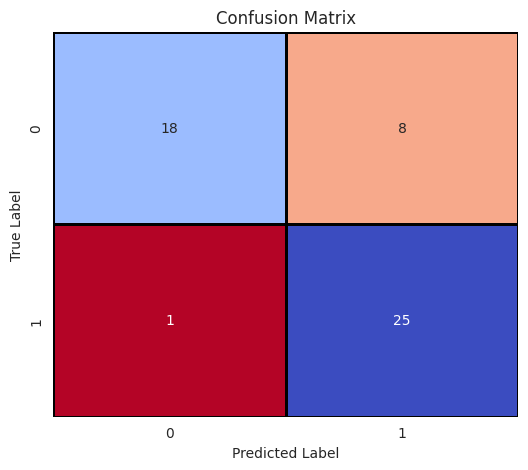

In [ ]:
#making a nicer confusion matrix:

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="coolwarm_r", cbar=False, linewidths=1, linecolor='black')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

model is working when the classes are balanced it can detect the difference in a closed school or an open school based on 4 variables

The next step is to be able to find closing schools in an imbalanced dataset... can do this by setting the threshold for predictions correctly

**Creating a new test set to see how the model handles extreme class imbalance...**


In [ ]:
#creating a new test set to represent the class imbalance
random_open_schools_2 = open_schools.sample(n = 1000, random_state= 42)

In [ ]:
test_data_2 = pd.concat([random_open_schools_2, closed_test])

In [ ]:
test_data_2

,target,total_expenses,non_operating grants,federal_grants,other_revenues
15359,0,17433538,0,4733398.0,0
8776,0,38110564,648215,4245400.0,3063057
13913,0,72745821,10563669,5162929.0,4263089
9351,0,480049475,0,63971200.0,56165720
5052,0,19704849,531457,2839682.0,924099
...,...,...,...,...,...
9766,1,35682539,0,4470406.0,754503
4576,1,15422382,0,2272119.0,15000
13507,1,858342,0,254698.0,0
7793,1,429793,0,34050.0,0


In [ ]:
X_test_2 = test_data_2.drop(["target"], axis = 1)
y_test_2 = test_data_2["target"]

In [ ]:
X_test_2_scaled = scaler.transform(X_test_2)

array([[-0.28929177, -0.238087  , -0.23789444, -0.23437696],
       [-0.23820156, -0.16679066, -0.28752489, -0.0977737 ],
       [-0.1526224 ,  0.92379738, -0.19421021, -0.04425583],
       ...,
       [-0.3302469 , -0.238087  , -0.69338791, -0.23437696],
       [-0.33130579, -0.238087  , -0.71582829, -0.23437696],
       [-0.0690833 , -0.238087  , -0.14132102, -0.17960003]])

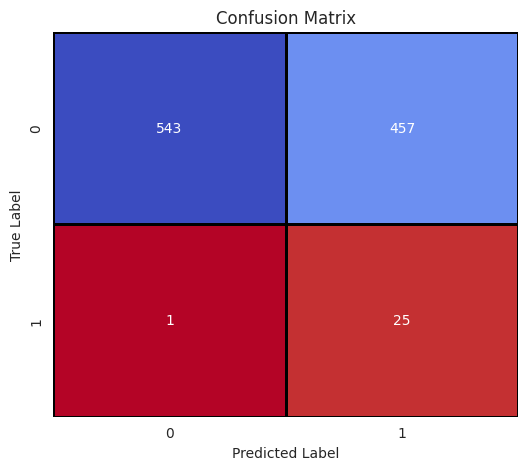

In [ ]:
y_preds_2 = model.predict(X_test_2_scaled)
cm2 = confusion_matrix(y_test_2, y_preds_2)


plt.figure(figsize=(6,5))
sns.heatmap(cm2, annot=True, fmt="d", cmap="coolwarm_r", cbar=False, linewidths=1, linecolor='black')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

So now the precision is very bad, on the good side we are catching almost all of the closed schools...

one issue is, since there are only 106 closed schools the training set is only learning on ~50 closed examples

**things that would help make the model more accurate**

- more data
- more features
- changing the threshold

In [ ]:
y_preds_2

array([1, 1, 0, ..., 1, 1, 1])

In [ ]:
#going to try to change the threshold
y_probs = model.predict_proba(X_test_2_scaled)
y_prob_closed = y_probs[:, 1] #the probability the schoool is closed

In [ ]:
len(y_probs)

1026

Text(0.5, 0, 'probability closed')

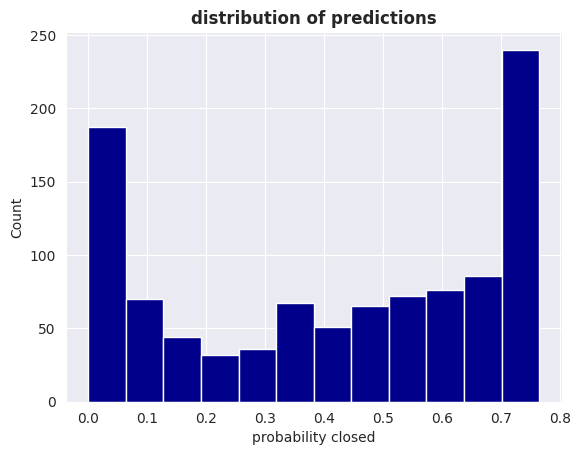

In [ ]:
sns.histplot(y_prob_closed, color = "darkblue", alpha = 1)
plt.title("distribution of predictions", fontdict = {"weight":"bold"})
plt.xlabel("probability closed")

In [ ]:
#going to change the threshold so that schools with a probability > .75 of being closed are classified as closed

In [95]:
new_preds = []
for i in y_prob_closed:
  if i > 0.39:
    pred = 1
    new_preds.append(pred)
  else:
    pred = 0
    new_preds.append(pred)


In [96]:
new_preds = np.array(new_preds)

In [97]:
cm3 = confusion_matrix(y_test_2, new_preds)

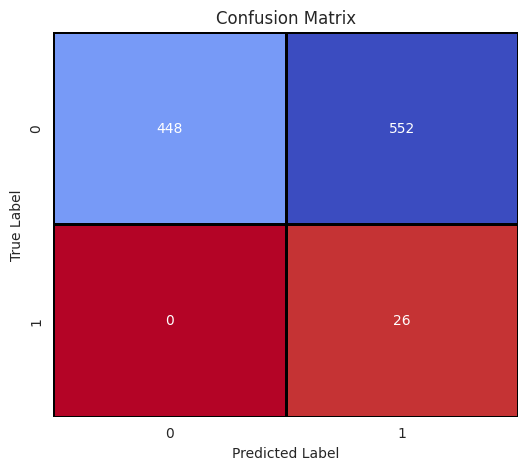

In [98]:
plt.figure(figsize=(6,5))
sns.heatmap(cm3, annot=True, fmt="d", cmap="coolwarm_r", cbar=False, linewidths=1, linecolor='black')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

adjusting the threshold did not signifiacntly improve performance 😞

it only allows the adjust the trade off between recall and precision.. here i was able to catch all of the closing schools but it came at the price of more misclassication

💡 **idea**
maybe its not so bad to misclassify alot of schools as ones as these can be considered high risk schools.. even though they may not be closed yet these schools may be on track to closing and the model is giving us a warning.

🚦 : schools can be classified as either open, high risk, or closed.. turning it into a multi class classification problem..

🥅 : from this we can conclude the schools that are safe investments are the schools predicted as 0.. even though alot of schools predicted as 1 are still open they can end up being dangerous investments becuase based on the data they have similar probabilites of being closed to schools that are actually closed.